# Déployez un modèle dans le cloud

- **Projet 8 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**


## Import des bibliothèques

In [1]:
import sagemaker # session
import sagemaker_pyspark
import pyspark # spark
import boto3 # S3 bucket
import os

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

from PIL import Image
import numpy as np
import tensorflow as tf # model

In [2]:
from platform import python_version

print(f'python version = {python_version()}')
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))

python version = 3.8.12
versions des bibliothèques utilisées:
sagemaker==2.92.1; pyspark==3.0.0; boto3==1.23.10; PIL.Image==9.0.1; numpy==1.20.3; tensorflow==2.7.1


## Configuration

In [3]:
S3_BUCKET='mc-oc-8'
DATA_FOLDER='data/train'
OUT_FOLDER='output'

### Create the SparkSession with the SageMaker Spark dependencies.

Examples:
- <https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-spark/pyspark_mnist/pyspark_mnist_xgboost.ipynb>

In [4]:

sess = sagemaker.Session()
aws_role = sagemaker.get_execution_role()
aws_region = boto3.Session().region_name

print(f'aws_region : {aws_region}')
print(f'aws_role : {aws_role}')

aws_region : eu-west-3
aws_role : arn:aws:iam::125534713363:role/service-role/AmazonSageMaker-ExecutionRole-20220707T161932


Note: AmazonSageMakerFullAccess role has access to configured S3 buckets - credentials not required

In [5]:
# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github repo under sagemaker-pyspark-sdk
# to learn how to connect to a remote EMR cluster running Spark from a Notebook Instance.
spark = (
    SparkSession.builder
    .config("spark.driver.extraClassPath", classpath)
    .master("local[*]")
    .appName("Fruit Image Classification")
    .getOrCreate()
)

spark

22/07/07 23:21:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Create images

On copie les images vers data

In [6]:
if not os.path.exists(DATA_FOLDER): os.makedirs(DATA_FOLDER)

In [7]:
import io

from PIL import Image  # https://pillow.readthedocs.io/en/4.3.x/
import requests  # http://docs.python-requests.org/en/master/


# example image url: https://github.com/Horea94/Fruit-Images-Dataset/tree/master/Training/
def download_image(url, image_file_path):
    # https://gist.github.com/mjdietzx/545fa2874b2688e9bcb71e2ee92cd5a0
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    # print(f'Image downloaded from url: {url} and saved to: {image_file_path}')


# test
url='https://raw.githubusercontent.com/Horea94/Fruit-Images-Dataset/master/Training/Raspberry/0_100.jpg'
if not os.path.exists(f'{DATA_FOLDER}/raspberry.jpg'):
    download_image(url,f'{DATA_FOLDER}/raspberry.jpg')

## Preview an image

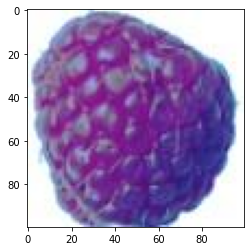

In [8]:
import matplotlib.pyplot as plt
img=Image.open(f'{DATA_FOLDER}/raspberry.jpg')
plt.imshow(img, cmap='gray')

## Transfer images to Bucket

In [9]:
def upload_s3(file_name, object_name=None, s3_bucket=S3_BUCKET):
    if object_name is None:
      object_name=file_name
    s3 = boto3.client('s3')
    with open(file_name, "rb") as f:
        s3.upload_fileobj(f, s3_bucket, object_name)

upload_s3(f'{DATA_FOLDER}/raspberry.jpg')

In [10]:
SRC= 'https://raw.githubusercontent.com/Horea94/Fruit-Images-Dataset/master/Training'
DEST = DATA_FOLDER


FRUITS=['Blueberry','Kiwi','Orange','Pineapple','Raspberry']
ANGLES= range(0,360,60)

def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

def copy_images():
    for fruit in FRUITS:
        src_path = f'{SRC}/{fruit}/'
        dest_path = f'{DEST}/{fruit}'
        makedirs(dest_path)
        for angle in ANGLES:
            filename =f'{angle}_100.jpg'
            try:
                if not os.path.exists(f'{dest_path}/{filename}'):
                    download_image(f'{src_path}/{filename}',f'{dest_path}/{filename}')
                upload_s3(f'{dest_path}/{filename}')
            except:
                # usually because image doesn't exist 
                continue

if not os.path.exists(f'{DEST}/{FRUITS[-1]}'):
    copy_images()